# Model for Average and StDev

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)
import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pylab as pl
from matplotlib import collections  as mc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## Data File Reading

In [2]:
path_folder = os.getcwd()

file_name_oa_offers = "offer_acceptance_offers.csv"
path_file_oa_offers = os.path.join(path_folder, file_name_oa_offers)
oa_offers = pd.read_csv(path_file_oa_offers)
print("Loaded offers df")
print(oa_offers.shape)

file_name_oa_orders = "offer_acceptance_orders.csv"
path_file_oa_orders = os.path.join(path_folder, file_name_oa_orders)
oa_orders = pd.read_csv(path_file_oa_orders)
print("Loaded orders df")
print(oa_orders.shape)

file_name_zipcode_coordinates = "zipcode_coordinates.csv"
path_file_zipcode_coordinates = os.path.join(path_folder, file_name_zipcode_coordinates)
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
zipcode_coordinates["X_COORD"] /= 1.0e6
zipcode_coordinates["Y_COORD"] /= 1.0e6
print("Loaded zipcodes df")
print(zipcode_coordinates.shape)

Loaded offers df
(707418, 14)
Loaded orders df
(280906, 17)
Loaded zipcodes df
(896, 3)


In [3]:
zipcode_coordinates["3DIGIT_ZIP"] = zipcode_coordinates["3DIGIT_ZIP"].astype(int).astype(str).str.zfill(3)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["DESTINATION_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .rename(columns={"X_COORD":"X_COORD_DEST","Y_COORD":"Y_COORD_DEST"})
    .drop(columns=["3DIGIT_ZIP"])
)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["ORIGIN_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .rename(columns={"X_COORD":"X_COORD_ORIG","Y_COORD":"Y_COORD_ORIG"})
    .drop(columns=["3DIGIT_ZIP"])
)

## Utility Functions

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib    
from matplotlib import cm

# fig ax bounding points
Y_UPPER_BOUND = 6.5
Y_LOWER_BOUND = 2.5
X_UPPER_BOUND = -7
X_LOWER_BOUND = -15

def bound_ax(ax):
    ax.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
    ax.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
    return ax

class Metro_Cluster:
    def __init__(
        self,
        df,
        x_column_name,
        y_column_name,
        cluster_method="kmeans",
        group_column_name = "GROUP",
        group_amount = 20
    ):
        assert cluster_method in ["kmeans","dbscan"]
        # df should have 3 columns. X, Y, and a 3rd dimension for density
        # and X and Y should form a superkey
        if cluster_method == "kmeans":
            np.random.seed(5)
            clusterer = KMeans(group_amount).fit(df)
            df[group_column_name] = np.array(clusterer.labels_)
        if cluster_method == "dbscan":
            eps=0.15
            self.eps = eps
            clusterer = DBSCAN(eps=eps).fit(df)
            df[group_column_name] = np.array(clusterer.labels_)+1
            print(len(set(clusterer.labels_)))
            print((set(clusterer.labels_)))
            group_amount = len(set(clusterer.labels_))
            df = df[df[group_column_name]!=0]
        self.df = df
        self.cluster_method = cluster_method
        self.x_column_name = x_column_name
        self.y_column_name = y_column_name
        self.clusterer = clusterer
        self.group_amount = group_amount
        self.group_column_name = group_column_name
        plt.scatter(self.df[self.x_column_name], 
                    self.df[self.y_column_name],
                    c=self.df[self.group_column_name],s=10,alpha=0.5,cmap="hsv")
        plt.title("Regions as Clusters")
    def build_cluster_df(
        self
    ):
        cluster_df = (
            self.df
            .groupby([self.group_column_name],as_index=False)
            .agg({self.x_column_name: np.mean, 
                  self.y_column_name: np.mean})
        )
        self.cluster_df = cluster_df
        plt.scatter(self.df[self.x_column_name], 
                    self.df[self.y_column_name],
                    c=self.df[self.group_column_name],s=10,alpha=0.5,cmap="hsv")
        plt.scatter(self.cluster_df[self.x_column_name], 
                    self.cluster_df[self.y_column_name],
                    edgecolors='black')
        return cluster_df

    def build_opt_pivot(
        self,
        temp_opt_pivot_column_name = "temp"
    ):
        cluster_df_melted = self.cluster_df.melt(
            id_vars=[self.group_column_name],
            value_vars=[self.x_column_name, self.y_column_name])

        cluster_df_melted.sort_values(["variable",self.group_column_name],inplace=True)

        cluster_df_melted[temp_opt_pivot_column_name] = (
            cluster_df_melted["variable"]+"_"+cluster_df_melted[self.group_column_name].astype(str)
        )
        #print(cluster_df_melted[temp_opt_pivot_column_name])
        opt_pivot = cluster_df_melted.set_index(cluster_df_melted[temp_opt_pivot_column_name])[["value"]].T
        opt_pivot_x_column_names = [column_name 
                                    for column_name in opt_pivot.columns 
                                    if self.x_column_name in column_name]
        opt_pivot_y_column_names = [column_name 
                                    for column_name in opt_pivot.columns 
                                    if self.y_column_name in column_name]
        self.opt_pivot = opt_pivot
        self.opt_pivot_x_column_names = opt_pivot_x_column_names
        self.opt_pivot_y_column_names = opt_pivot_y_column_names
        return opt_pivot

    def get_proximities(
        self,
        df, 
        x_column_name, 
        y_column_name,
        proximity_column_names,
        zero_division_preventer = 1,
        
    ):
        if self.cluster_method == "kmeans":
            zero_division_preventer = 1
            x_distances = (np.expand_dims(df[x_column_name].values,1) - self.opt_pivot[self.opt_pivot_x_column_names].values)**2
            y_distances = (np.expand_dims(df[y_column_name].values,1) - self.opt_pivot[self.opt_pivot_y_column_names].values)**2
            distances = x_distances + y_distances            
            proximities = 1/(distances+zero_division_preventer)
            proximities_sum = np.sum(proximities,axis=1,keepdims=True)
            proximities /= proximities_sum
            return pd.DataFrame(proximities,columns=proximity_column_names)
        elif self.cluster_method == "dbscan":
            zero_division_preventer = 1
            x_distances = (np.expand_dims(df[x_column_name].values,1) - self.opt_pivot[self.opt_pivot_x_column_names].values)**2
            y_distances = (np.expand_dims(df[y_column_name].values,1) - self.opt_pivot[self.opt_pivot_y_column_names].values)**2
            distances = x_distances + y_distances
            proximities = 1/(distances+zero_division_preventer)
            proximities_sum = np.sum(proximities,axis=1,keepdims=True)
            proximities /= proximities_sum
            return pd.DataFrame(proximities,columns=proximity_column_names[1:])  

In [5]:
def dataclean_ftl_duplicate_references(oa_orders):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that have reference numbers that show up more than once, as those rows are incorrectly labeled FTL
    '''
    assert "TRANSPORT_MODE" in oa_orders.columns
    assert "REFERENCE_NUMBER" in oa_orders.columns
    oa_orders_ftl = oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]
    oa_orders_non_ftl = oa_orders[oa_orders["TRANSPORT_MODE"]!="FTL"]
    oa_orders_ftl_unique = oa_orders_ftl.drop_duplicates(subset=["REFERENCE_NUMBER"],keep=False)
    oa_orders = pd.concat([oa_orders_non_ftl, oa_orders_ftl_unique],axis=0)
    oa_orders = oa_orders.reset_index(drop=True)
    assert (oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]["REFERENCE_NUMBER"].value_counts()==1).all()
    return oa_orders
def dataclean_ftl_nonquote(oa):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that don't have quote as the transport mode
    '''
    assert "OFFER_TYPE" in oa.columns
    assert "TRANSPORT_MODE" in oa.columns    
    oa = oa[~((oa["TRANSPORT_MODE"]=="FTL") & (oa["OFFER_TYPE"]!="quote"))]
    return oa
def dataclean_pool_reference_numbers_discrepancy(oa_offers):
    '''
    Some oa_offers rows have a mismatch between the length of its reference numbers and its pooled/quote labelling
    These rows are wrong.
    '''
    assert "OFFER_TYPE" in oa_offers.columns
    assert "NUM_REFERENCE_NUMBERS" in oa_offers.columns    
    oa_offers = oa_offers[((oa_offers["OFFER_TYPE"]=="pool") == (oa_offers["NUM_REFERENCE_NUMBERS"]>1))]
    return oa_offers  

def temp_build_ohe(series,column_name):
    series = series.fillna("NULL")
    return pd.get_dummies(series, prefix=column_name)
def add_ohe_columns(df, ohe_columns):
    df = pd.concat([df, ohe_columns],axis=1)
    return df

def get_log_column(loggable_numerical_column):
    # return column.apply(lambda x: np.log(x+1))
    return loggable_numerical_column.apply(np.log1p)
def add_log_column_to_df(df, column_name):
    '''
    Applies np.log1p (LOG(x+1)) to a numerical column with values >= 0
    And adds it as a column to the df
    '''
    new_column_name = "LOG({0})".format(column_name)
    loggable_numerical_column = df[column_name]
    df[new_column_name] = get_log_column(loggable_numerical_column)
    return df
def get_pd_datetime_column(date_column):
    return pd.to_datetime(date_column)
def convert_pd_datetime_column(df, date_column_name):
    date_column = df[date_column_name] 
    df[date_column_name] = get_pd_datetime_column(date_column)
    return df
def get_boolean_to_num_column(boolean_column):
    return (boolean_column).astype(float)
def convert_boolean_to_num_column(df, boolean_column_name):
    boolean_column = df[boolean_column_name] 
    df[boolean_column_name] = get_boolean_to_num_column(boolean_column)
    return df
def get_list_of_reference_numbers_column(column):
    '''
    cleans the raw reference column from a string to a list of strings
    '''
    result = (column
    ).str.replace("\n"," "
    ).str.replace(" ",""
    ).str.replace('''"''',''
    ).str.replace("[",""
    ).str.replace("]",""
    ).str.split(",")
    return result

def time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name):
    start_day_column = pd.to_datetime(df[time_start_column_name]).dt.date
    end_day_column = pd.to_datetime(df[time_end_column_name]).dt.date
    num_business_days_column = np.busday_count( start_day_column , end_day_column)
    num_seconds_in_a_day = 60*60*24
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    days_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 'd')
    )
    weekends_between_end_and_start_column = days_between_end_and_start_column - num_business_days_column
    weekends_between_end_and_start_column_in_seconds = weekends_between_end_and_start_column * num_seconds_in_a_day
    return weekends_between_end_and_start_column_in_seconds
def get_time_subtraction(df, time_end_column_name, time_start_column_name):
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    seconds_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 's')
    )
    weekend_removal = 0
    # TODO: debug time_subtraction_weekends_removal's datetime y/m/d formatting to make this error stop happening
    try:
        weekend_removal = time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name)
    except:
        print("Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in")
    seconds_between_end_and_start_column -= weekend_removal
    return seconds_between_end_and_start_column    



# helper functions to add columns specifically to oa orders
def add_time_between_order_and_deadline_column(oa_orders, column_name="TIME_BETWEEN_ORDER_AND_DEADLINE"):
    assert "PICKUP_DEADLINE_PST" in list(oa_orders.columns)
    assert "ORDER_DATETIME_PST" in list(oa_orders.columns)

    seconds_between_order_and_deadline_column = get_time_subtraction(oa_orders, "PICKUP_DEADLINE_PST","ORDER_DATETIME_PST")
    oa_orders[column_name] = seconds_between_order_and_deadline_column
    return oa_orders
def add_distance_column(oa_orders, column_name="APPROXIMATE_DRIVING_ROUTE_MILEAGE"):
    assert "X_COORD_DEST" in list(oa_orders.columns)
    assert "Y_COORD_DEST" in list(oa_orders.columns)
    assert "X_COORD_ORIG" in list(oa_orders.columns)
    assert "Y_COORD_ORIG" in list(oa_orders.columns)
    
    
    distance_column = (
        (oa_orders["X_COORD_DEST"] - oa_orders["X_COORD_ORIG"])**2 + \
        (oa_orders["Y_COORD_DEST"] - oa_orders["Y_COORD_ORIG"])**2
    )
    oa_orders[column_name] = distance_column
    return oa_orders

def add_month_column(oa_orders,column_name="MONTH"):
    assert "PICKUP_DEADLINE_PST" in list(oa_orders.columns)
    month_column = pd.to_datetime(oa_orders["PICKUP_DEADLINE_PST"]).dt.month
    oa_orders[column_name] = month_column
    return oa_orders

def add_weekday_column(oa_orders,column_name="DAY"):
    assert "PICKUP_DEADLINE_PST" in list(oa_orders.columns)
    day_column = pd.to_datetime(oa_orders["PICKUP_DEADLINE_PST"]).dt.weekday
    oa_orders[column_name] = day_column
    return oa_orders


#def add_ohe_month_columns(oa_orders,column_names=None):
#    assert "PICKUP_DEADLINE_PST" in list(oa_orders.columns)
#    ohe_month = temp_build_ohe(pd.to_datetime(oa_orders["PICKUP_DEADLINE_PST"]).dt.month, "MONTH")#
#    oa_orders = add_ohe_columns(oa_orders, ohe_month)
#    return oa_orders

#def add_ohe_weekday_columns(oa_orders,column_names=None):
#    assert "PICKUP_DEADLINE_PST" in list(oa_orders.columns)
#    ohe_weekday = temp_build_ohe(pd.to_datetime(oa_orders["PICKUP_DEADLINE_PST"]).dt.weekday, "DAY")
#    oa_orders = add_ohe_columns(oa_orders, ohe_weekday)
#    return oa_orders

# helper functions to add columns specifically to oa offers
def add_cleaned_reference_numbers_column(oa_offers,column_name="REFERENCE_NUMBERS"):
    '''
    Adds column with reference numbers cleaned into a list.
    '''
    assert "REFERENCE_NUMBER" in list(oa_offers.columns)
    oa_offers[column_name] = get_list_of_reference_numbers_column(oa_offers["REFERENCE_NUMBER"])
    return oa_offers
def add_num_reference_numbers_column(oa_offers,column_name="NUM_REFERENCE_NUMBERS"):
    '''
    Adds number of reference numbers by a carrier (used to find pooled)
    '''
    assert "REFERENCE_NUMBERS" in list(oa_offers.columns)
    oa_offers[column_name] = oa_offers["REFERENCE_NUMBERS"].apply(len)
    return oa_offers
def add_offer_type_is_pooled_column(oa_offers,column_name="OFFER_TYPE_IS_POOLED"):
    '''
    Adds if offer type is pooled
    '''
    assert "OFFER_TYPE" in list(oa_offers.columns)
    oa_offers[column_name] = (oa_offers["OFFER_TYPE"]=="pool").astype(float)
    return oa_offers

# helper functions to add columns specifically to oa (the join of oa offers and oa orders)
def add_offer_order_amount_column(oa,column_name='ORDER_OFFER_AMOUNT'):
    '''
    Adds column denoting number of offers per order ("reference number") to oa_offers
    '''
    assert 'REFERENCE_NUMBERS' in list(oa.columns)
    reference_numbers_column_name = "REFERENCE_NUMBERS"
    oa = oa.merge(
        oa.groupby([reference_numbers_column_name]).size().reset_index(name=column_name), 
        on=[reference_numbers_column_name])
    return oa
def add_time_between_offer_and_deadline_column(oa, column_name="TIME_BETWEEN_OFFER_AND_DEADLINE"):
    assert 'CREATED_ON_HQ' in list(oa.columns)
    assert 'PICKUP_DEADLINE_PST' in list(oa.columns)
    seconds_between_offer_and_deadline_column = get_time_subtraction(oa, "PICKUP_DEADLINE_PST","CREATED_ON_HQ")
    oa[column_name] = seconds_between_offer_and_deadline_column
    return oa
def add_distance_over_offer_time_column(oa, column_name="DISTANCE_OVER_OFFER_TIME"):
    assert "APPROXIMATE_DRIVING_ROUTE_MILEAGE" in list(oa.columns)
    assert "TIME_BETWEEN_OFFER_AND_DEADLINE" in list(oa.columns)
    distance_over_time_column = (oa["APPROXIMATE_DRIVING_ROUTE_MILEAGE"] / oa["TIME_BETWEEN_OFFER_AND_DEADLINE"])
    oa[column_name] = distance_over_time_column
    return oa
def add_distance_over_order_time_column(oa, column_name="DISTANCE_OVER_ORDER_TIME"):
    assert "APPROXIMATE_DRIVING_ROUTE_MILEAGE" in list(oa.columns)
    assert "TIME_BETWEEN_ORDER_AND_DEADLINE" in list(oa.columns)
    distance_over_time_column = (oa["APPROXIMATE_DRIVING_ROUTE_MILEAGE"] / oa["TIME_BETWEEN_ORDER_AND_DEADLINE"])
    oa[column_name] = distance_over_time_column
    return oa
def temp_build_metro_cluster(oa):
    assert "X_COORD_DEST" in list(oa.columns)
    assert "X_COORD_ORIG" in list(oa.columns)
    assert "Y_COORD_DEST" in list(oa.columns)
    assert "Y_COORD_ORIG" in list(oa.columns)
    assert "ORDER_OFFER_AMOUNT" in list(oa.columns)

    zipcode_density = (oa.groupby(["X_COORD_DEST","Y_COORD_DEST"],as_index=False).agg({"ORDER_OFFER_AMOUNT":np.sum}))
    density_adjuster = 10
    zipcode_density["ORDER_OFFER_AMOUNT"] = zipcode_density["ORDER_OFFER_AMOUNT"].apply(np.log1p)/density_adjuster
    metro_cluster = Metro_Cluster(zipcode_density,"X_COORD_DEST","Y_COORD_DEST",cluster_method="kmeans")
    metro_cluster.build_cluster_df()
    metro_cluster.build_opt_pivot()
    return metro_cluster

def add_metro_cluster_columns(oa, metro_cluster, orig_proximity_column_names=None, dest_proximity_column_names=None):
    '''
    Clusters all the zipcodes into N groups, then one-hot-encodes the order's orig and dest zipcodes
    into those groups (for a total of 2*N columns). These columns aren't really one-hot-encoded like binary,
    but are like softmaxes for how close a zipcode is to a centroid of a cluster.
    For example, let's say all the zipcodes are clustered into 3 groups A, B, C 
    if a given order had its orig zipcode very close to B, and its dest zipcode was equidistant from all groups,
    its result would like [0.1, 0.8, 0.1] + [0.33, 0.33, 0.33]
    or conjoined as [0.1, 0.8, 0.1, 0.33, 0.33, 0.33], with columns 
    ["ORIG_GROUP0", "ORIG_GROUP1","ORIG_GROUP2","DEST_GROUP0", "DEST_GROUP1","DEST_GROUP2"]
    '''
    assert "X_COORD_DEST" in list(oa.columns)
    assert "X_COORD_ORIG" in list(oa.columns)
    assert "Y_COORD_DEST" in list(oa.columns)
    assert "Y_COORD_ORIG" in list(oa.columns)

    if orig_proximity_column_names is None:
        orig_proximity_column_names = ["ORIG_"+metro_cluster.group_column_name+str(i) 
                                       for i in range(metro_cluster.group_amount)]
        
    orig_proximity_columns = metro_cluster.get_proximities(oa,
                                                "X_COORD_ORIG",
                                                "Y_COORD_ORIG",
                                                orig_proximity_column_names)
    oa = pd.concat([oa, orig_proximity_columns],axis=1)
    
    if dest_proximity_column_names is None:
        dest_proximity_column_names = ["DEST_"+metro_cluster.group_column_name+str(i) 
                                       for i in range(metro_cluster.group_amount)]
    dest_proximity_columns = metro_cluster.get_proximities(oa,
                                                "X_COORD_DEST",
                                                "Y_COORD_DEST",
                                                dest_proximity_column_names)
    oa = pd.concat([oa, dest_proximity_columns],axis=1)
    return oa

In [6]:
from sklearn.decomposition import PCA
def view_pca(X,y):
    pca = PCA(2)
    Z = pca.fit_transform(X)
    fig, axs = plt.subplots()
    axs.scatter(Z[:,0], Z[:,1], c=y,s=1, alpha=0.1)
    return pca

## Data Cleaning

In [7]:
# data cleaning offers
# In this part, I'm just adding columns to the oa offers table

oa_offers_boolean_column_names = ['SELF_SERVE', 'IS_OFFER_APPROVED',
           'AUTOMATICALLY_APPROVED', 'MANUALLY_APPROVED', 'WAS_EVER_UNCOVERED',
           'COVERING_OFFER', 'LOAD_DELIVERED_FROM_OFFER', 'RECOMMENDED_LOAD', 'VALID']
oa_offers_date_column_names = ["CREATED_ON_HQ"]
oa_offers_categorical_column_names = ["OFFER_TYPE"]
oa_offers_loggable_numerical_column_names = ["RATE_USD"]

oa_offers = add_cleaned_reference_numbers_column(oa_offers)

oa_offers = add_num_reference_numbers_column(oa_offers)

oa_offers = dataclean_pool_reference_numbers_discrepancy(oa_offers)

offer_type_is_pooled_column_name = "OFFER_TYPE_IS_POOLED"
oa_offers = add_offer_type_is_pooled_column(oa_offers,column_name=offer_type_is_pooled_column_name)
oa_offers_boolean_column_names += [offer_type_is_pooled_column_name]

for column_name in oa_offers_date_column_names:
    oa_offers = convert_pd_datetime_column(oa_offers, column_name)
for column_name in oa_offers_boolean_column_names:
    oa_offers = convert_boolean_to_num_column(oa_offers, column_name)
for column_name in oa_offers_loggable_numerical_column_names:
    oa_offers = add_log_column_to_df(oa_offers, column_name)

In [8]:
# data cleaning orders
# In this part, I'm just adding columns to the oa orders table

oa_orders_boolean_column_names = ['FD_ENABLED', 'EXCLUSIVE_USE_REQUESTED','HAZARDOUS', 
                                  'REEFER_ALLOWED', 'STRAIGHT_TRUCK_ALLOWED','LOAD_TO_RIDE_REQUESTED']
oa_orders_loggable_numerical_column_names = ["ESTIMATED_COST_AT_ORDER","APPROXIMATE_DRIVING_ROUTE_MILEAGE",
                                             "PALLETIZED_LINEAR_FEET","LOAD_BAR_COUNT"]
oa_orders_date_column_names = ["ORDER_DATETIME_PST","PICKUP_DEADLINE_PST"]
oa_orders_categorical_column_names = ["DELIVERY_TIME_CONSTRAINT","TRANSPORT_MODE"]

# Matt said that any duplicate references is likely an error
oa_orders = dataclean_ftl_duplicate_references(oa_orders)

oa_orders = add_cleaned_reference_numbers_column(oa_orders)

distance_column_name = "APPROXIMATE_DRIVING_ROUTE_MILEAGE"
oa_orders = add_distance_column(oa_orders,column_name=distance_column_name)
oa_orders_loggable_numerical_column_names += [distance_column_name]

time_between_order_and_deadline_column_name = "TIME_BETWEEN_ORDER_AND_DEADLINE"
oa_orders = add_time_between_order_and_deadline_column(oa_orders,column_name=time_between_order_and_deadline_column_name)


#month_column_names = ["MONTH_"+str(x) for x in range(1,13)]
#oa_orders = add_ohe_month_columns(oa_orders, column_names=month_column_names)
#oa_orders_boolean_column_names += month_column_names

#weekday_column_names = ["DAY_"+str(x) for x in range(0,7)]
#oa_orders = add_ohe_weekday_columns(oa_orders, column_names=weekday_column_names)
#oa_orders_boolean_column_names += weekday_column_names

month_column_name = "MONTH"
oa_orders = add_month_column(oa_orders, column_name=month_column_name)
oa_orders_categorical_column_names += [month_column_name]

weekday_column_name = "DAY"
oa_orders = add_weekday_column(oa_orders, column_name=weekday_column_name)
oa_orders_categorical_column_names += [weekday_column_name]

for column_name in oa_orders_categorical_column_names:
    ohe_columns = temp_build_ohe(oa_orders[column_name],column_name=column_name)
    ohe_column_names = list(ohe_columns.columns)
    oa_orders_boolean_column_names += ohe_column_names
    oa_orders = add_ohe_columns(oa_orders, ohe_columns)

for column_name in oa_orders_date_column_names:
    oa_orders = convert_pd_datetime_column(oa_orders, column_name)
for column_name in oa_orders_boolean_column_names:
    oa_orders = convert_boolean_to_num_column(oa_orders, column_name)
for column_name in oa_orders_loggable_numerical_column_names:
    oa_orders = add_log_column_to_df(oa_orders, column_name)

oa_orders = oa_orders.drop(columns=["REFERENCE_NUMBER"])

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in


In [10]:
# joining the oa_offers and oa_orders into a new table called oa
# oa will have 2 new columns "SD_LOG(RATE_USD)" and "ORDER_OFFER_AMOUNT" 
# which are the standard deviation of the logged rate_usd, and the actual number of offers

log_rate_usd_column_name = "LOG(RATE_USD)"
count_reference_numbers_column_name = "ORDER_OFFER_AMOUNT"
sd_log_rate_usd_column_name = "SD_LOG(RATE_USD)"
# adding a duplicate of the rates column to apply standard deviaton later on during the group by
oa_offers[sd_log_rate_usd_column_name] = oa_offers[log_rate_usd_column_name]
# adding a duplicate of the rates column to apply count later on during the group by
oa_offers[count_reference_numbers_column_name] = oa_offers["REFERENCE_NUMBER"]


# Recall that in oa_offers, the column "REFERENCE_NUMBERS" are lists of reference number strings, with at max 13 items
assert (type(oa_offers["REFERENCE_NUMBERS"].values[0]) == list)
print("oa_offers[REFERENCE_NUMBERS] can have up to # items:", 
      (oa_offers["REFERENCE_NUMBERS"].apply(len)).max())
print("oa_offers[REFERENCE_NUMBERS].values[0] is", (oa_offers["REFERENCE_NUMBERS"].values[0]))

# So we should apply the pandas explode function to the REFERENCE_NUMBERS column in oa_offers
oa_offers_exploded = oa_offers.explode(["REFERENCE_NUMBERS"])
# Now, oa_offers has more rows, and reference numbers are now strings
assert (type(oa_offers_exploded["REFERENCE_NUMBERS"].values[0]) == str)
print("oa_offers_exploded[REFERENCE_NUMBERS].values[0] is", (oa_offers_exploded["REFERENCE_NUMBERS"].values[0]))
print("oa_offers_exploded[REFERENCE_NUMBERS].values[1] is", (oa_offers_exploded["REFERENCE_NUMBERS"].values[1]))
assert ((oa_offers["REFERENCE_NUMBERS"].apply(len)).sum() == oa_offers_exploded.shape[0])

# now, the newly exploded oa_offers must be groupby'd on REFERENCE_NUMBERS to be in the same joinable level as oa orders
aggdict = dict()
aggdict[log_rate_usd_column_name] = np.mean 
aggdict[sd_log_rate_usd_column_name] = np.std # standard deviation
aggdict[count_reference_numbers_column_name] = "count"
oa_offers_groupby = oa_offers_exploded.groupby(["REFERENCE_NUMBERS"],as_index=False).agg(aggdict)





print("")
# Recall that in oa_orders, the column "REFERENCE_NUMBERS" are also lists of reference number strings,
# but they only have 1 item
assert (type(oa_orders["REFERENCE_NUMBERS"].values[0]) == list)
print("oa_orders[REFERENCE_NUMBERS].values[0] is", (oa_orders["REFERENCE_NUMBERS"].values[0]))
assert oa_orders["REFERENCE_NUMBERS"].apply(len).max() == 1
assert oa_orders["REFERENCE_NUMBERS"].apply(len).min() == 1
assert ((oa_orders["REFERENCE_NUMBERS"].apply(len)).sum() == oa_orders.shape[0])

# Since it's just 1 item, exploding REFERENCE_NUMBERS is no different 
# than just doing oa_orders["REFERENCE_NUMBERS"] = oa_orders["REFERENCE_NUMBERS"].apply(lambda x: x[0])
oa_orders_exploded = oa_orders.explode(["REFERENCE_NUMBERS"])
assert ((oa_orders.shape[0] == oa_orders_exploded.shape[0]))
assert (type(oa_orders_exploded["REFERENCE_NUMBERS"].values[0]) == str)
print("oa_orders_exploded[REFERENCE_NUMBERS].values[0] is", oa_orders_exploded["REFERENCE_NUMBERS"].values[0])




# finally merging oa_offers and oa_orders
foreign_key_column_name = "REFERENCE_NUMBERS"
        
temp_oa_orders = oa_orders_exploded
temp_oa_offers = oa_offers_groupby
oa = temp_oa_orders.merge(temp_oa_offers, on=[foreign_key_column_name])

oa_offers[REFERENCE_NUMBERS] can have up to # items: 13
oa_offers[REFERENCE_NUMBERS].values[0] is ['ce3548db155049cc1ccce2da041cec607942e4f779fc2dee81d5756a93508e49', '0034d727920c7ec0d25c4e40248ddc4d487c239b647da070e706ce6b01f2385b']
oa_offers_exploded[REFERENCE_NUMBERS].values[0] is ce3548db155049cc1ccce2da041cec607942e4f779fc2dee81d5756a93508e49
oa_offers_exploded[REFERENCE_NUMBERS].values[1] is 0034d727920c7ec0d25c4e40248ddc4d487c239b647da070e706ce6b01f2385b

oa_orders[REFERENCE_NUMBERS].values[0] is ['820fb5eab2adc4de77f4bdf1a72c06958bf1b02eb8b4e9155eae7de4736db739']
oa_orders_exploded[REFERENCE_NUMBERS].values[0] is 820fb5eab2adc4de77f4bdf1a72c06958bf1b02eb8b4e9155eae7de4736db739


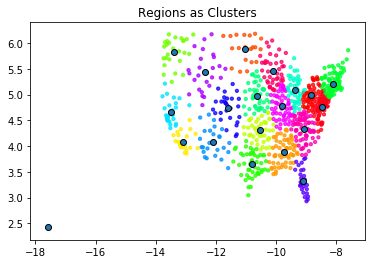

In [11]:
oa_boolean_column_names = []
oa_loggable_numerical_column_names = []
oa_numerical_column_names = []

distance_over_order_time_column_name = "DISTANCE_OVER_ORDER_TIME"
oa = add_distance_over_order_time_column(oa,column_name=distance_over_order_time_column_name)
oa_numerical_column_names += [distance_over_order_time_column_name]

metro_cluster = temp_build_metro_cluster(oa)
oa = add_metro_cluster_columns(oa, metro_cluster)

#offer_order_amount_column_name = "ORDER_OFFER_AMOUNT"
#oa = add_offer_order_amount_column(oa, column_name=offer_order_amount_column_name)
oa_loggable_numerical_column_names += [count_reference_numbers_column_name]

for column_name in oa_loggable_numerical_column_names:
    oa = add_log_column_to_df(oa, column_name)

In [13]:
oa_collapsed_orders = oa

In [14]:
is_singleton = (oa_collapsed_orders[count_reference_numbers_column_name]==1).mean()
is_null = oa_collapsed_orders[sd_log_rate_usd_column_name].isnull().mean()
assert is_singleton == is_null
oa_collapsed_orders = oa_collapsed_orders.fillna(0)

In [15]:
oa_collapsed_orders = oa_collapsed_orders.drop(columns=[
    'ORDER_DATETIME_PST', 
    'PICKUP_DEADLINE_PST',
    'ORIGIN_3DIGIT_ZIP', 
    'DESTINATION_3DIGIT_ZIP',
    'LOG(ESTIMATED_COST_AT_ORDER)',
    'ESTIMATED_COST_AT_ORDER',
    'REFERENCE_NUMBERS',
])
oa_collapsed_orders = oa_collapsed_orders.drop(columns=[
    'DELIVERY_TIME_CONSTRAINT',
    'TRANSPORT_MODE',
])


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

In [18]:
class Temp_Order_Model_Builder:
    def __init__(
        self,
        df,
        target_column_name,
        weight_column_name=None,
    ):
        self.df = df
        self.target_column_name = target_column_name
        self.weight_column_name = weight_column_name        
        self.X = self.df.drop(columns=[self.target_column_name])
        self.y = self.df[self.target_column_name]
    def _check_weight(self):
        if self.weight_column_name is None:
            return False
        else:
            return True
    def transform_y(self, y=None, inplace=False):
        if y is None: 
            y = self.y;
        if inplace==True: 
            self.y = y
        return y
    def transform_X(self, X=None, inplace=False):
        if X is None: 
            X = self.X;
        
        top_n = 30
        target_column_name = self.target_column_name
        df = self.df
        assert target_column_name in list(df.columns)

        if self._check_weight():
            weight_column_name = self.weight_column_name
            weight_column = df[weight_column_name]
            df.drop(columns=[weight_column_name], inplace=True)
        
        top_n_correlated_selected_column_names = (
            df.corr()[target_column_name]
            .abs()
            .sort_values(ascending=False)
            .head(top_n+1).index[1:])
        
        self.top_n_correlated_selected_column_names = top_n_correlated_selected_column_names
        X = X[top_n_correlated_selected_column_names]
        
        if self._check_weight():
            weight_column_name = self.weight_column_name
            #weight_column = self.df[weight_column_name]
            X[weight_column_name] = weight_column
        
        if inplace==True: 
            self.X = X
        return X
    def set_split(self, X=None, y=None, stratify=None):
        if X is None:
            X = self.X
        if y is None:
            y = self.y
        stratify = stratify
        np.random.seed(1)
        X_train, X_test, y_train, y_test = train_test_split(X,y,stratify)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        if self._check_weight():
            weight_column_name = self.weight_column_name
            X_train_weight_column = self.X_train[weight_column_name]
            self.X_train = self.X_train.drop(columns=[weight_column_name])
            self.X_test = self.X_test.drop(columns=[weight_column_name])
            self.X_train_weight_column = X_train_weight_column
            self.temp_weight_column = X_train_weight_column
        else:
            pass
    def train_model(self, model, X_train=None, y_train=None):
        if X_train is None:
            X_train = self.X_train
        if y_train is None:
            y_train = self.y_train

        if self._check_weight():
            weight_column = self.X_train_weight_column
            model.fit(X_train, y_train,sample_weight=weight_column)
        else:
            model.fit(X_train, y_train)
            print("Cross Val Scores:",cross_val_score(model, X_train, y_train, cv=4))
        self.model = model
        return model
    def test_model(self, model=None,X_test=None,y_test=None):
        if model is None:
            model = self.model
        if X_test is None:
            X_test = self.X_test
        if y_test is None:
            y_test = self.y_test
        predictions = model.predict(X_test)
        return predictions

In [19]:
class Temp_Order_Classification_Model_Builder (Temp_Order_Model_Builder):
    def __init__(
        self,
        df,
        target_column_name,
        class_amount = 2,
        weight_column_name=None,
    ):
        super(Temp_Order_Classification_Model_Builder, self).__init__(df, target_column_name,weight_column_name)
        self.class_amount = class_amount
    def _split_as_n_ordinal_levels(self, y,class_amount=None):
        if class_amount is None:
            class_amount = 2 #4
        percentiles = [np.percentile(y,x) for x in np.arange(0,100,100/class_amount)[1:]]
        self.percentiles = percentiles
        ordinals = np.zeros(y.shape[0])
        for percentile in percentiles:
            ordinals += (y>=percentile).astype(float)
        y = ordinals
        return y
    def set_split(self, X=None, y=None, stratify=None):
        if X is None:
            X = self.X
        if y is None:
            y = self.y
        if stratify is None:
            stratify = self.y
        np.random.seed(1)
        X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=stratify)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        if self._check_weight():
            weight_column_name = self.weight_column_name
            X_train_weight_column = self.X_train[weight_column_name]
            self.X_train = self.X_train.drop(columns=[weight_column_name])
            self.X_test = self.X_test.drop(columns=[weight_column_name])
            self.X_train_weight_column = X_train_weight_column
            self.temp_weight_column = X_train_weight_column
        else:
            pass
    def transform_y(self, y=None, inplace=False
                   ):
        if y is None: 
            y = self.y;
        y = self._split_as_n_ordinal_levels(y, class_amount=self.class_amount)
        if inplace==True: 
            self.y = y
        return y
    def eval_model(self, predictions,y_test=None):
        if y_test is None: 
            y_test = self.y_test
        print("Confusion Matrix:\n", confusion_matrix(predictions,y_test,normalize="true"))
        #print("ROC AUC Score:",roc_auc_score(predictions,y_test))
        if self.class_amount==2:
            print("ROC AUC Score", roc_auc_score(y_test,predictions))

In [20]:
class Temp_Order_Regression_Model_Builder (Temp_Order_Model_Builder):
    def __init__(
        self,
        df,
        target_column_name,
        weight_column_name=None,
    ):
        super(Temp_Order_Regression_Model_Builder, self).__init__(df, target_column_name,weight_column_name)
    def set_split(self, X=None, y=None, stratify=None):
        if X is None:
            X = self.X
        if y is None:
            y = self.y
        np.random.seed(1)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        if self._check_weight():
            weight_column_name = self.weight_column_name
            X_train_weight_column = self.X_train[weight_column_name]
            self.X_train = self.X_train.drop(columns=[weight_column_name])
            self.X_test = self.X_test.drop(columns=[weight_column_name])
            self.X_train_weight_column = X_train_weight_column
            self.temp_weight_column = X_train_weight_column
        else:
            pass
    def transform_y(self, y=None, inplace=False,
                    update_df=False
):
        if y is None: 
            y = self.y;
        if inplace==True: 
            self.y = y
        if update_df==True:
            self.df[self.target_column_name] = y
        return y
    def eval_model(self, predictions,y_test=None):
        if y_test is None: 
            y_test = self.y_test
        print("Corr between Regression Predicted Y & Actual Y:", np.corrcoef(predictions, (y_test))[0][1])

In [22]:
target_column_name="LOG(RATE_USD)"
weight_column_name=None #"LEAD_TIME"
input_df = oa_collapsed_orders.drop(columns=[
    "SD_LOG(RATE_USD)",
    "ORDER_OFFER_AMOUNT",
    "LOG(ORDER_OFFER_AMOUNT)"
])

avg_model_builder = Temp_Order_Regression_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name
)
avg_model_builder.transform_y(inplace=True,update_df=True)
avg_model_builder.transform_X(inplace=True)
avg_model_builder.set_split()
avg_model_builder.train_model(LinearRegression())
predictions = avg_model_builder.test_model()
avg_model_builder.eval_model(predictions)
avg_model_builder
#plt.scatter(predictions, avg_model_builder.y_test,s=5,alpha=0.2)

Cross Val Scores: [0.72872097 0.64614312 0.72951856 0.72011622]
Corr between Regression Predicted Y & Actual Y: 0.8497806083745434


In [23]:
target_column_name="ORDER_OFFER_AMOUNT"
weight_column_name=None #"LEAD_TIME"
input_df = oa_collapsed_orders.drop(columns=[
    "SD_LOG(RATE_USD)",
    "LOG(RATE_USD)",
    "LOG(ORDER_OFFER_AMOUNT)"
])
predicted_avg_column = avg_model_builder.model.predict(
    input_df[avg_model_builder.top_n_correlated_selected_column_names])
input_df["PRED_LOG(RATE_USD)"] = predicted_avg_column
num_model_builder = Temp_Order_Classification_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name
)
num_model_builder.transform_y(inplace=True)
num_model_builder.transform_X(inplace=True)
num_model_builder.set_split()
num_model_builder.train_model(RandomForestClassifier(10))
predictions = num_model_builder.test_model()
num_model_builder.eval_model(predictions)
num_model_builder

Cross Val Scores: [0.61111901 0.612939   0.61251244 0.60715504]
Confusion Matrix:
 [[0.52656491 0.47343509]
 [0.31811708 0.68188292]]
ROC AUC Score 0.6041655337573049


In [24]:
target_column_name="SD_LOG(RATE_USD)"
weight_column_name=None #"LEAD_TIME"
input_df = oa_collapsed_orders.drop(columns=[
    "ORDER_OFFER_AMOUNT",
    "LOG(RATE_USD)",
    "LOG(ORDER_OFFER_AMOUNT)"
])
predicted_avg_column = avg_model_builder.model.predict(
    input_df[avg_model_builder.top_n_correlated_selected_column_names])
input_df["PRED_LOG(RATE_USD)"] = predicted_avg_column

predicted_num_column = num_model_builder.model.predict(
    input_df[num_model_builder.top_n_correlated_selected_column_names])
input_df["PRED_ORDER_OFFER_AMOUNT"] = predicted_num_column

sd_model_builder = Temp_Order_Classification_Model_Builder(
    df=input_df,
    target_column_name=target_column_name,
    weight_column_name=weight_column_name
)
sd_model_builder.transform_y(inplace=True)
sd_model_builder.transform_X(inplace=True)
sd_model_builder.set_split()
sd_model_builder.train_model(RandomForestClassifier(10))
predictions = sd_model_builder.test_model()
sd_model_builder.eval_model(predictions)
sd_model_builder

Cross Val Scores: [0.67197498 0.67447746 0.67134935 0.66923558]
Confusion Matrix:
 [[0.65913684 0.34086316]
 [0.31453773 0.68546227]]
ROC AUC Score 0.6712956292764053
